# LANL Earthquakes Experiment
# Spectrogram Analysis

This notebook continues from the point where Spectrogram_librosa.ipynb created a directory of spectrograms made using librosa library.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import seaborn as sns
import re
from pathlib import Path
import pickle as pkl
from time import time
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
import os, sys
from warnings import warn
import itertools
from sklearn.model_selection import KFold, StratifiedKFold
from fastai.vision import *
from fastai.metrics import error_rate#, mean_absolute_error

In [3]:
# 0 = load; 1 = predict; 2 = train.
RUN_CV = 0
RUN_CLASSIFICATION = 0
RUN_REGRESSION = 1

In [4]:
# Path consts
BASE = Path('../Data')
TRAIN = BASE/'train_spec2'

# NN consts
BS = 32 # 64 already causes OOM error in the regression
MIXUP = True

# Data consts
SIZE = (187,147)
meta = pd.read_csv(TRAIN/'train_spec_meta.csv')
n_hops = len(meta)

## Cross Validation

A validation fold consists of 20% of the segments, in batches of 40 sequential segments (after x6 augmentation).

In [5]:
def plot_folds(meta, K_FOLDS=None, COLORS = ('k','b','r','g','y')):
    if K_FOLDS is None:
        K_FOLDS = len(np.unique(meta.fold))
    
    plt.figure(figsize=(10,6))
    for k in range(K_FOLDS):
        plt.plot(np.argwhere(meta.fold==k), meta.loc[meta.fold==k,'time'], COLORS[k]+'.', label=k)
    plt.xlabel('Segment\n(with x6 overlapping)')
    plt.ylabel('TTF')
    plt.title('Train Data Folding')
    plt.grid()
    plt.legend()
    
    plt.figure(figsize=(10,6))
    for k in range(K_FOLDS):
        sns.distplot(meta.loc[meta.fold==k,'time'], color=COLORS[k], hist=False, label=k)
    plt.xlabel('TTF')
    plt.title('Train Data Folding')
    plt.legend()
    plt.grid()

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


(array([40, 41, 42, 43, 44]), -65.32755719763087, 11.029759743884108)

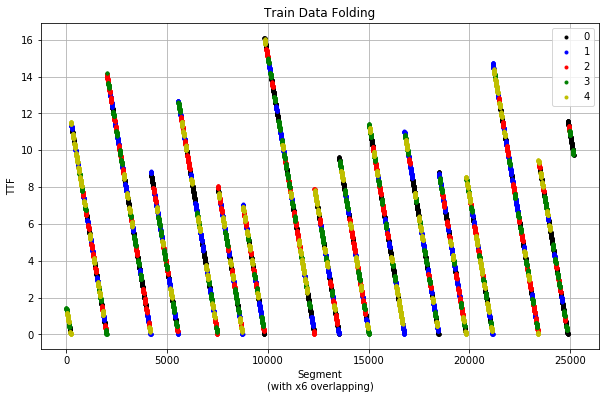

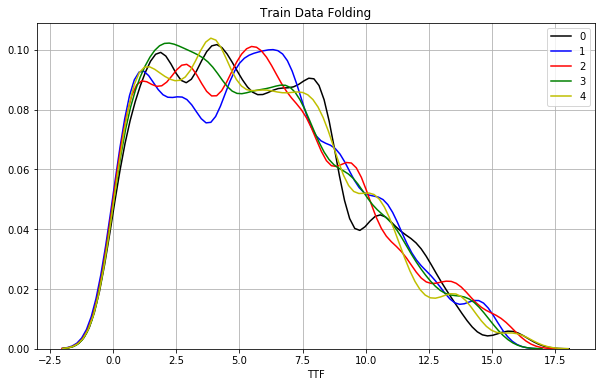

In [6]:
# Validation configuration
validation_type = 'load' if RUN_CV<2 else 'CV'
valid_rate = 0.2
K_FOLDS = int(1/valid_rate)
batch_size = 40
np.random.seed(0)


# Create validation set
if validation_type == 'random':
    n_batches = n_hops // batch_size
    n_val_batches = int(valid_rate * n_batches)
    validation_batches = np.random.choice(range(n_batches), n_val_batches, replace=False)
    val_ids = np.concatenate([np.arange(i0*batch_size,(i0+1)*batch_size,dtype=int) for i0 in validation_batches])
    
elif validation_type == 'sequential':
    val_ids = np.array(range(int((1-valid_rate)*n_hops),n_hops))
    
elif validation_type == 'CV':
    meta['fold'] = 0
    hops = meta.loc[np.arange(0, n_hops-batch_size, batch_size)]
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True)
    for k, (train_index, valid_index) in enumerate(skf.split(hops['filename'], hops['class'])):
        val_ids = np.concatenate([np.arange(batch_size*i,batch_size*(i+1)) for i in valid_index])
        meta.loc[val_ids, 'fold'] = k
    meta.to_csv(TRAIN/'train_spec_meta.csv', index=False)


# Summary & save/load
if validation_type == 'load':
    # Note: all these variables are actually useful only for a single fold.
    # for a full CV, use instead the column 'fold' in meta.
    val_ids, val_set, train_mean, train_std = pkl.load(open(TRAIN/'validation_set.pkl','rb'))
else:
    val_set = set(meta.iloc[val_ids]['filename'])
    train_mean = np.mean([m for i,m in enumerate(meta['mean']) if i not in val_ids])
    train_std = np.sqrt(np.mean([m for i,m in enumerate(meta['var']) if i not in val_ids])) # not really std...
    pkl.dump((val_ids,val_set,train_mean,train_std), open(TRAIN/'validation_set.pkl','wb'))

if 'fold' in meta.columns:
    plot_folds(meta)
    
(val_ids[:5], train_mean, train_std)

In [7]:
#meta = meta.head(1000)

## Model analyzer

In [8]:
def analyze_errors(y0, y, tit, folds=None,
                   class_limits=np.array([0,1,2,3,4,5,6,7,8,10,12,14,99]), COLORS=('k','b','r','g','y')):
    tit = '['+tit+']'
    
    print('Sizes:\t', y0.shape, y.shape)
    errs = y - y0
    print('MAE:\t', np.abs(errs).mean())
    
    if folds is not None:
        print('MAE per fold:\t', [round(np.abs(errs[folds==k]).mean(),2) for k in range(len(np.unique(folds)))])
        fig, axs = plt.subplots(1,3, figsize=(15,8))
        for k in range(len(np.unique(folds))):
            sns.distplot(y[folds==k], color=COLORS[k], hist=False, label=k, ax=axs[0])
        axs[0].set_xlabel('Predicted TTF [s]')
        axs[0].set_title(tit+' Predictions per Folder')
        axs[0].legend()
        axs[0].grid()
        for k in range(len(np.unique(folds))):
            sns.distplot(errs[folds==k], color=COLORS[k], hist=False, label=k, ax=axs[1])
        axs[1].set_xlabel('Error')
        axs[1].set_title(tit+' Predictions per Folder')
        axs[1].legend()
        axs[1].grid()
        sns.boxplot(x='Folder', y='Absolute Error [s]', data=pd.DataFrame({'Folder':folds, 'Absolute Error [s]':np.abs(errs)}),
                    showmeans=True, ax=axs[2])
        axs[2].set_title(tit)
    
    fig, axs = plt.subplots(1,2, figsize=(15,4))
    axs[0].plot(y, color='r', label='Model Predictions')
    axs[0].plot(y0, color='g', label='Ground Truth')
    axs[0].set_ylabel('TTF [s]')
    axs[0].set_title(tit)
    axs[0].grid()
    axs[0].legend()
    axs[1].plot(errs)
    axs[1].set_ylabel('Error [s]')
    axs[1].set_title(tit)
    axs[1].grid()
    plt.tight_layout()
    
    fig, axs = plt.subplots(1,2, figsize=(15,4))
    sns.distplot(y, color='r', ax=axs[0], label='Model Predictions')
    sns.distplot(y0, color='g', ax=axs[0], label='Ground Truth')
    axs[0].set_title(tit)
    axs[0].set_xlabel('TTF [s]')
    axs[0].grid()
    axs[0].legend()
    sns.distplot(errs, ax=axs[1])
    axs[1].set_title(tit)
    axs[1].set_xlabel('Error [s]')
    axs[1].grid()
    plt.tight_layout()
    
    fig, axs = plt.subplots(1,3, figsize=(15,4))
    b, a = polyfit(y0, y, 1)
    axs[0].plot(y0, a*y0+b, 'r-')
    axs[0].plot(y0, y, 'b,')
    axs[0].set_title(tit)
    axs[0].set_xlabel('True TTF')
    axs[0].set_ylabel('Predicted TTF')
    axs[0].grid()
    b, a = polyfit(y0, errs, 1)
    axs[1].plot(y0, a*y0+b, 'r-')
    axs[1].plot(y0, errs, 'b,')
    axs[1].set_title(tit)
    axs[1].set_xlabel('True TTF')
    axs[1].set_ylabel('Error')
    axs[1].grid()
    b, a = polyfit(y, errs, 1)
    axs[2].plot(y, a*y+b, 'r-')
    axs[2].plot(y, errs, 'b,')
    axs[2].set_title(tit)
    axs[2].set_xlabel('Predicted TTF')
    axs[2].set_ylabel('Error')
    axs[2].grid()
    plt.tight_layout()
    
    order = [f'{a:d}-{b:d}' for a,b in zip(class_limits[:-1],class_limits[1:])]
    cls0 = [[f'{a:d}-{b:d}' for a,b in zip(class_limits[:-1],class_limits[1:]) if a<=t<b][0] for t in y0]
    cls = [[f'{a:d}-{b:d}' for a,b in zip(class_limits[:-1],class_limits[1:]) if a<=t<b][0] for t in y]
    df = pd.DataFrame({'True TTF':cls0, 'Predicted TTF':cls, 'Predicted TTF numeric':y, 'Error':errs})
    
    # consider adding number of observations in annotation:
    # https://python-graph-gallery.com/58-show-number-of-observation-on-violinplot/
    fig, axs = plt.subplots(3,1, figsize=(15,12))
    sns.violinplot(x='True TTF', y='Predicted TTF numeric', data=df, order=order, scale='width', showmeans=True, ax=axs[0])
    axs[0].set_ylabel('Predicted TTF')
    axs[0].set_title(tit)
    axs[0].grid()
    sns.violinplot(x='True TTF', y='Error', data=df, order=order, scale='width', showmeans=True, ax=axs[1])
    axs[1].set_title(tit)
    axs[1].grid()
    sns.violinplot(x='Predicted TTF', y='Error', data=df, order=order, scale='width', showmeans=True, ax=axs[2])
    axs[2].set_title(tit)
    axs[2].grid()
    plt.tight_layout()

In [9]:
def class_vs_reg(y0, yr, yc, class_limits=np.array([0,1,2,3,4,5,6,7,8,10,12,14,99])):
    
    errs_class = yc - y0
    errs_reg = yr - y0
    print('Samples:\t', y0.shape)
    print('MAE - Classification:\t', np.mean(np.abs(errs_class)))
    print('MAE - Regression:\t', np.mean(np.abs(errs_reg)))
    
    order = [f'{a:d}-{b:d}' for a,b in zip(class_limits[:-1],class_limits[1:])]
    cls0 = [[f'{a:d}-{b:d}' for a,b in zip(class_limits[:-1],class_limits[1:]) if a<=t<b][0] for t in y0]
    #cls = [[f'{a:d}-{b:d}' for a,b in zip(class_limits[:-1],class_limits[1:]) if a<=t<b][0] for t in y]
    df = pd.DataFrame({
        'True TTF': cls0+cls0,
        'Model': len(cls0)*['Classification'] + len(cls0)*['Regression'],
        'Prediction': np.concatenate((yc, yr)),
        'Error': np.concatenate((errs_class, errs_reg)),
        'Absolute Error': np.concatenate((np.abs(errs_class), np.abs(errs_reg))),
        'Classification Bucket': 2*[int(t) for t in yc],
        'Regression Bucket': 2*[int(t) for t in yr]
    })
    
    fig, axs = plt.subplots(5,1, figsize=(15,25))
    sns.violinplot(ax=axs[0], x="True TTF", y="Prediction", hue="Model", data=df, order=order,
                   palette="muted", split=True, scale="width", inner="quartile", showmeans=True)
    axs[0].grid()
    sns.violinplot(ax=axs[1], x="True TTF", y="Error", hue="Model", data=df, order=order,
                   palette="muted", split=True, scale="width", inner="quartile", showmeans=True)
    axs[1].grid()
    sns.boxplot(ax=axs[2], x="True TTF", y="Absolute Error", hue="Model", data=df, order=order, showmeans=True, linewidth=2.5)
#     sns.violinplot(ax=axs[1], x="True TTF", y="Absolute Error", hue="Model", data=df, order=order,
#                    palette="muted", split=True, scale="width", inner="quartile", showmeans=True)
    axs[2].grid()
    sns.boxplot(ax=axs[3], x="Classification Bucket", y="Absolute Error", hue="Model", data=df, showmeans=True, linewidth=2.5)
    axs[3].grid()
    sns.boxplot(ax=axs[4], x="Regression Bucket", y="Absolute Error", hue="Model", data=df, showmeans=True, linewidth=2.5)
    axs[4].grid()

## Classification

In [10]:
def classification_data(meta, fold, verbose=1):
    validation_set = {nm: k for nm,k in zip(meta.filename,meta.fold)}
    
    data = ImageDataBunch.create_from_ll(
        (ImageList.from_df(meta[['filename','class']], path=TRAIN, folder=None, suffix='', cols=0)
                    .split_by_valid_func(lambda nm: validation_set[os.path.basename(nm)]==fold)
                    .label_from_df(label_delim=None, cols=1)),
        ds_tfms=[], size=SIZE, bs=BS
    ).normalize()
    # Note: normalize() uses by default self.stats = self.batch_stats() = [torch.mean,torch.std].
    # This should be good since we have very weird values and we wish to normalize them to nore conventional values.
    # RESNET34 kind of assumes a more specific input distribution (imagenet_stats),
    # but as far as we don't have convergence issues, we'll stick to this.
    
    classification_data_info(data, verbose)
    
    return data

def classification_data_info(data, verbose):
    if verbose >= 1:
        print(data)
        plt.figure(figsize=(8,5))
        sns.distplot(classes2times([data.label_list.train.y.classes[i] for i in data.label_list.train.y.items]),
                     color='b', hist=False, label='Train')
        sns.distplot(classes2times([data.label_list.valid.y.classes[i] for i in data.label_list.valid.y.items]),
                     color='r', hist=False, label='Valid')
        plt.xlabel('TTF [s]')
        plt.legend()
        plt.grid()
    if verbose >= 2:
        data.show_batch(rows=3, figsize=(9,6))
    
def classes2times(cls):
    return np.array([class2time(c) for c in cls])

def class2time(c):
    t = (int(c[:2])+int(c[-2:]))/2
    return min(t,13)

In [11]:
def classification_learn(data, lr_range=(3e-5,3e-4), cycles=(4,4), mixup=True,
                         save_label=None, load=False, predict=True, find_lr=True):
    # initialize
    learn = cnn_learner(data, models.resnet34, metrics=error_rate)
    if mixup:
        learn.mixup()
    
    # train
    if load:
        if load == 'freezed':
            learn.load(f'model_spec_class_resnet34_freezed_mxp{mixup:d}_'+save_label)
        elif load == 'unfreezed':
            learn.load(f'model_spec_class_resnet34_unfreezed_mxp{mixup:d}_'+save_label)
        else:
            raise ValueError("load must be either 'freezed' or 'unfreezed'.")
    
    else:
        # TODO track training errors (on both train & validation sets)
        if cycles[0] > 0:
            learn.fit_one_cycle(cycles[0])
            if save_label is not None:
                learn.save(f'model_spec_class_resnet34_freezed_mxp{mixup:d}_'+save_label)

        if find_lr:
            learn.lr_find()
            learn.recorder.plot()

        if cycles[1] > 0:
            learn.unfreeze()
            learn.fit_one_cycle(cycles[1], max_lr=slice(lr_range[0],lr_range[1]))
            if save_label is not None:
                learn.save(f'model_spec_class_resnet34_unfreezed_mxp{mixup:d}_'+save_label)
                
    # predict
    if predict:
        yv_ml, yv_med = class_predict(learn)
    else:
        yv_ml, yv_med = None, None
    
    return learn, yv_ml, yv_med

def class_predict(learn):
    classes = learn.data.label_list.train.y.classes
    ti = [int(c[:2]) for c in classes]
    tf = [min(int(c[-2:]),16) for c in classes]
    yv = [learn.predict(x) for x in tqdm_notebook(learn.data.label_list.valid.x)]
    # yv_ml = np.array([str(y[0]) for y in yv], dtype='S8')
    yv_ml = classes2times([str(y[0]) for y in yv])
    yv_med = np.array([get_med(y[2],ti,tf) for y in yv])
    return yv_ml, yv_med

def get_med(probs, ti, tf):
    cs = np.cumsum(probs)
    i0 = int(np.argwhere(cs>0.5)[0][0])
    ti = ti[i0]
    tf = tf[i0]
    c0 = cs[i0-1] if i0>0 else 0
    return ti + (tf-ti) * (0.5-c0) / (cs[i0]-c0)

In [12]:
def classification_interpretation(learn=None, interp=None, detailed=2):
    if interp is None:
        interp = ClassificationInterpretation.from_learner(learn)
    
    print('MAE:\t{0:.5f}'.format(confusion2mae(interp.confusion_matrix())))
    
    if detailed >= 1:
        interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
        
    if detailed >= 2:
        interp.plot_top_losses(9, figsize=(15,11), largest=False, heatmap = True)
        interp.plot_top_losses(9, figsize=(15,11), largest=False, heatmap = False)
        interp.plot_top_losses(9, figsize=(15,11), largest=True,  heatmap = False)
        interp.plot_top_losses(9, figsize=(15,11), largest=True,  heatmap = True)
        
    return interp

def confusion2mae(M, class_limits=np.array([0,1,2,3,4,5,6,7,8,10,12,16])):
    class_centers = (class_limits[1:]+class_limits[:-1])/2
    class_lengths = np.diff(class_limits)
    tot_err = 0
    n = 0
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            n += M[i,j]
            tot_err += M[i,j] * (np.abs(class_centers[i]-class_centers[j]) if i!=j else class_lengths[i]/4)
    return tot_err / n

In [13]:
if RUN_CLASSIFICATION:

    LOAD_ONLY = 'freezed' if RUN_CLASSIFICATION==1 else False

    K = len(np.unique(meta.fold))
    assert(K == K_FOLDS), 'Bad number of folders.'
    print(f'Number of folders:\t{K:d}')
    n_classes = len(np.unique(meta['class']))
    print(f'Number of classes:\t{n_classes:d}')

    YV_ML = np.zeros(len(meta))
    YV_MED = np.zeros(len(meta))
    confusions = [np.zeros((n_classes, n_classes), dtype=int)]
    for k in range(K):
        print('Iteration: ',k)
        data_class = classification_data(meta, k, verbose = (2 if k==0 else 0))
        learn_class, yv_ml, yv_med = classification_learn(
            data_class, cycles=(4,3), mixup=MIXUP, save_label=f'{k:d}', load=LOAD_ONLY)
        YV_ML[meta.fold==k] = yv_ml
        YV_MED[meta.fold==k] = yv_med
        try:
            interp_class = classification_interpretation(learn_class, detailed = (2 if k==0 else 0))
            confusions += [interp_class.confusion_matrix()]
        except:
            warn('Classification interpretation failed.')

    with open(TRAIN/f'classification_results_mixup{MIXUP:d}_freezed.pkl','wb') as fd:
        pkl.dump((YV_ML, YV_MED, confusions), fd)
    
    
else:
    
    with open(TRAIN/f'classification_results_mixup{MIXUP:d}_freezed.pkl','rb') as fd:
        YV_ML, YV_MED, confusions = pkl.load(fd)

Sizes:	 (25165,) (25165,)
MAE:	 2.5978315710846367
MAE per fold:	 [2.77, 2.76, 2.43, 2.51, 2.5]


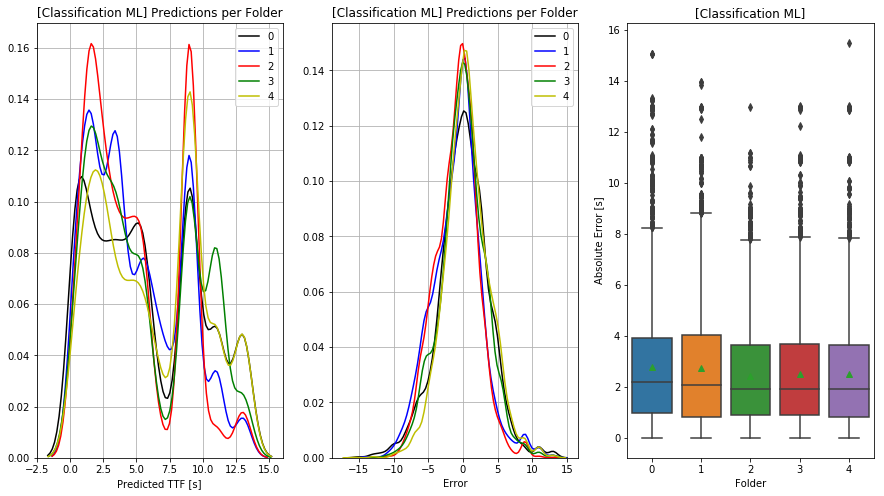

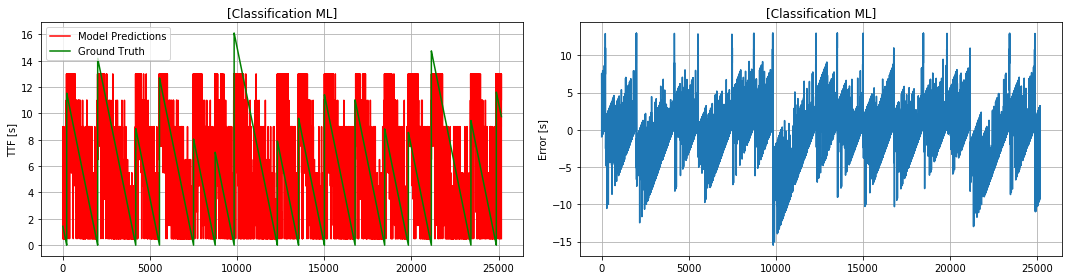

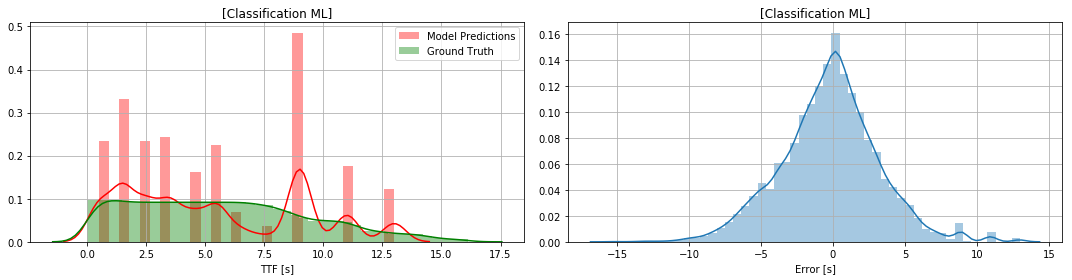

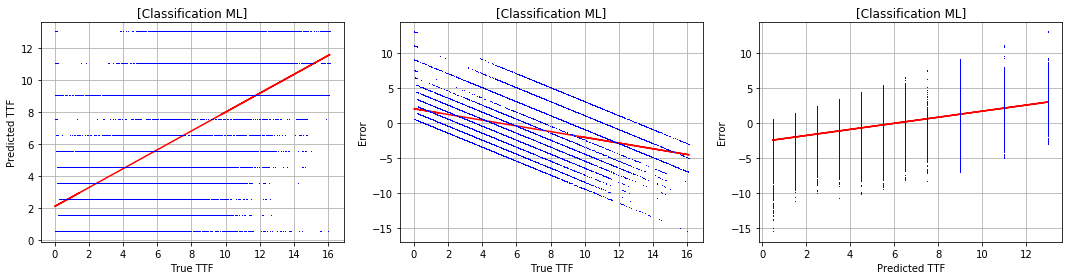

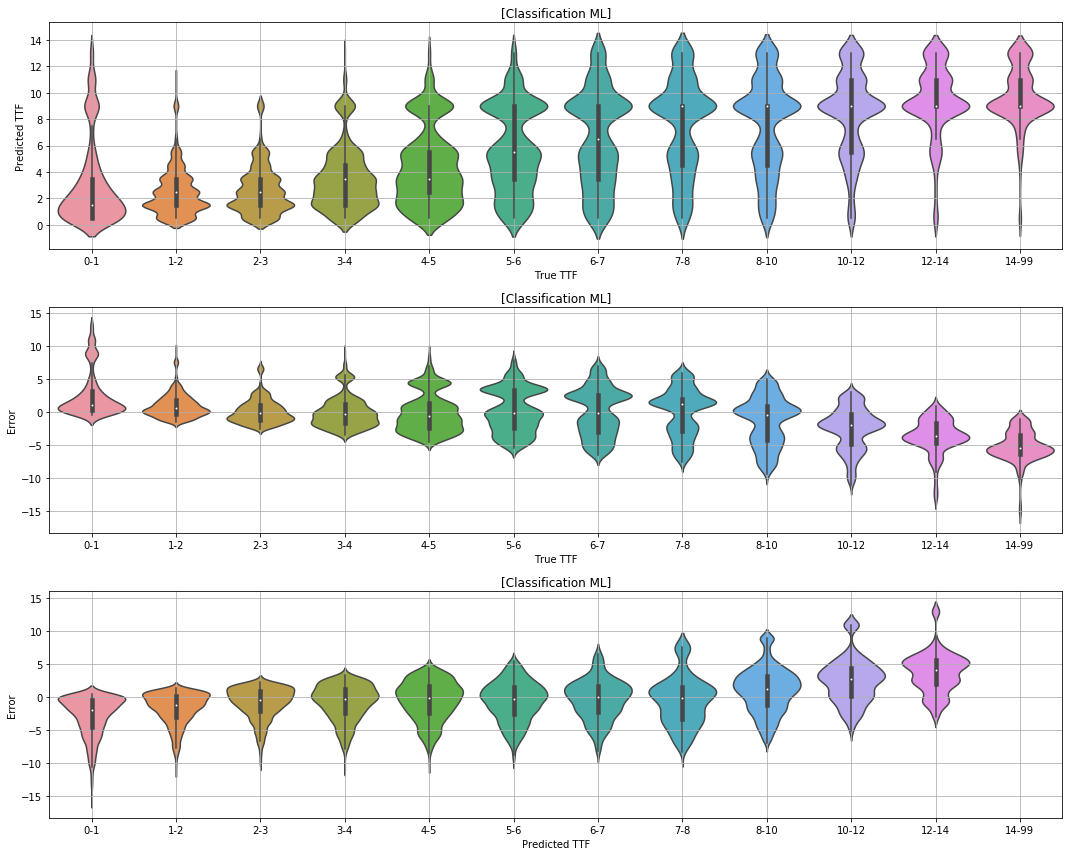

In [14]:
analyze_errors(meta.time, YV_ML, 'Classification ML', meta.fold.values)

Sizes:	 (25165,) (25165,)
MAE:	 2.208656225178909
MAE per fold:	 [2.15, 2.43, 2.21, 2.17, 2.07]


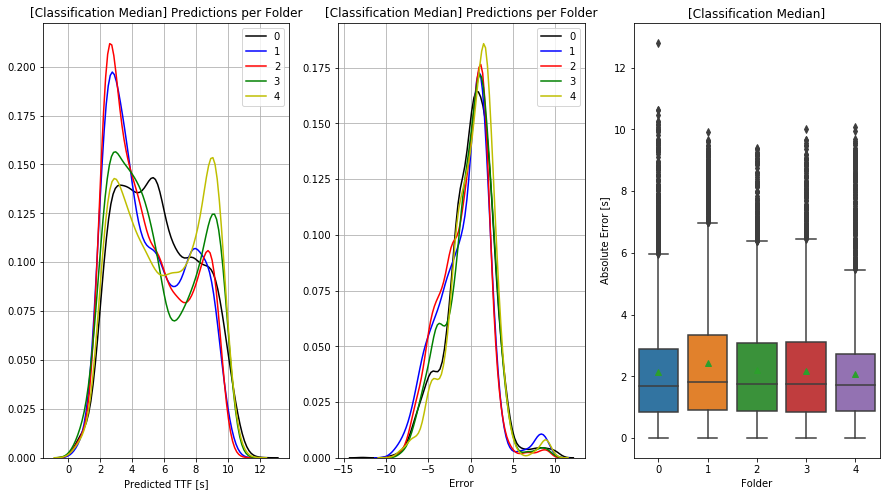

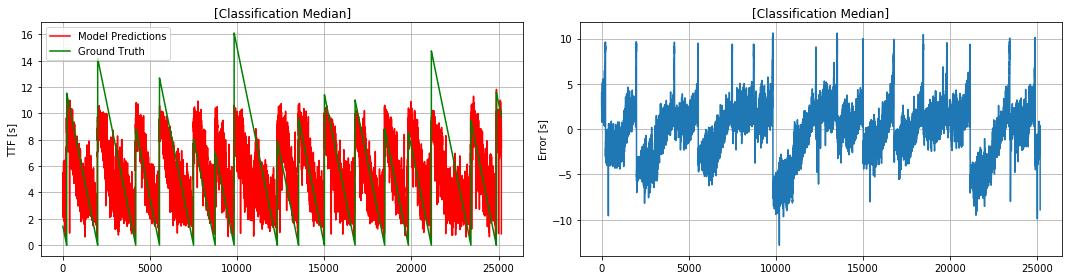

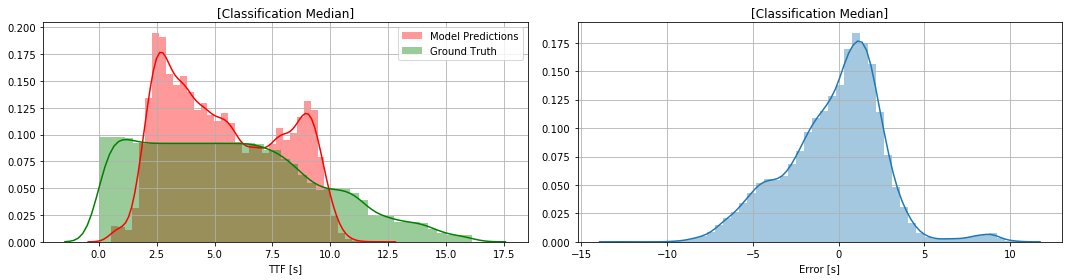

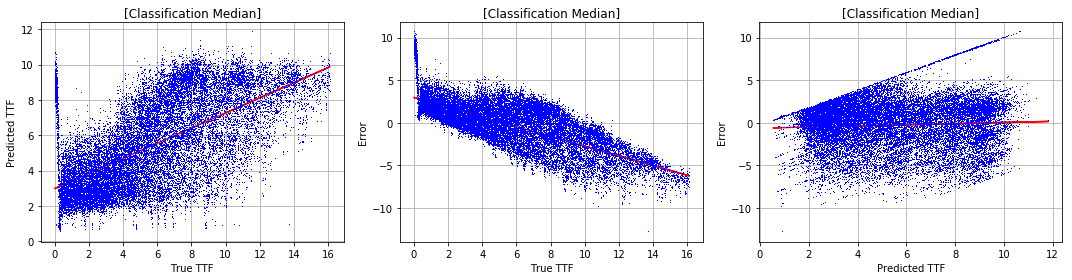

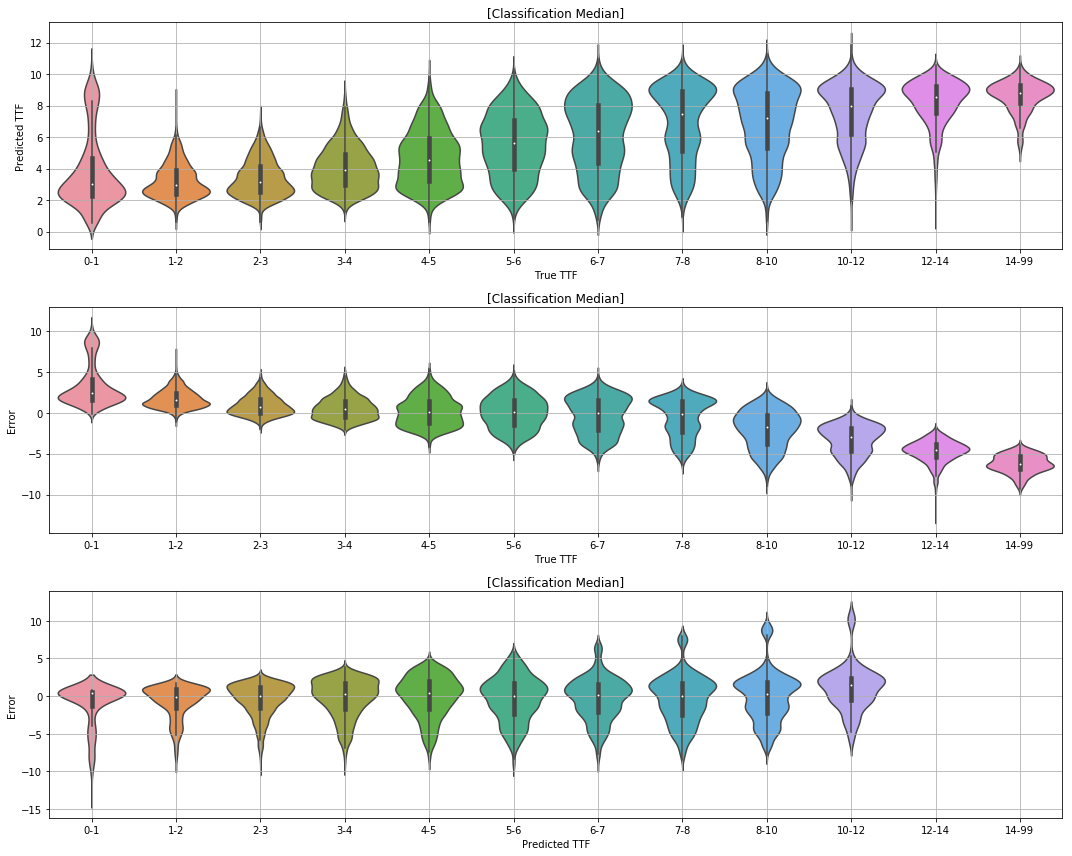

In [15]:
analyze_errors(meta.time, YV_MED, 'Classification Median', meta.fold.values)

Samples:	 (25165,)
MAE - Classification:	 2.208656225178909
MAE - Regression:	 2.5978315710846367


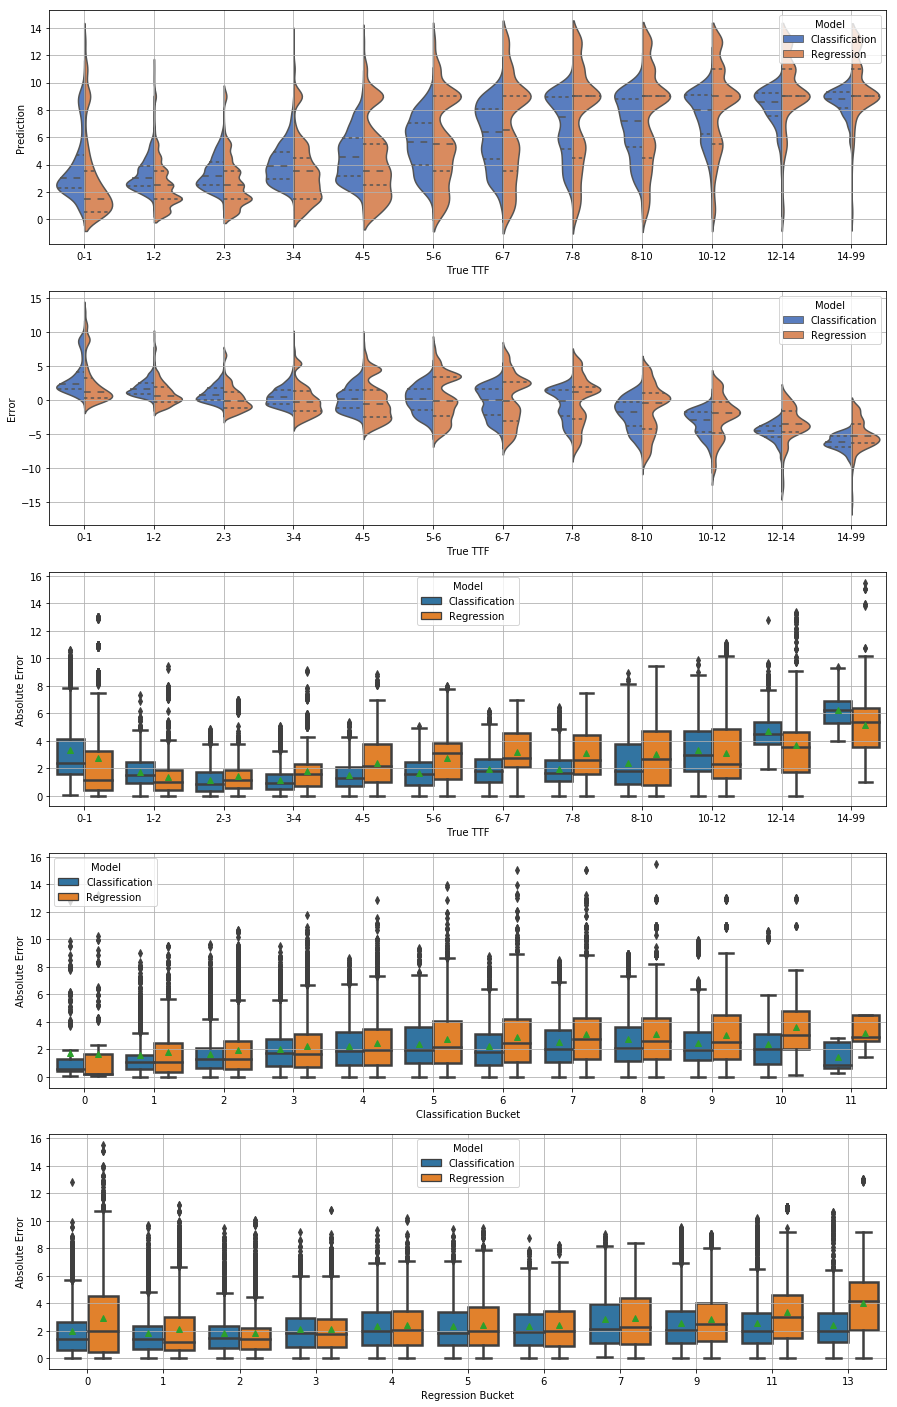

In [16]:
# Note: in the figure, Regression->ML, Classification->Median
class_vs_reg(meta.time, YV_ML, YV_MED)

In [17]:
torch.cuda.empty_cache()

## Regression

Note: range of MAE should be between 2.0 (excellent) and 2.2 (quite bad), for CV that takes groups of 20 x3-augmented-segments (i.e. 7 original segments, or 1.05M samples) as homogeneous buckets.

In [18]:
def regression_data(meta, fold, verbose=1):
    validation_set = {nm: k for nm,k in zip(meta.filename,meta.fold)}
    
    data = (PointsItemList.from_df(meta[['filename','time']], TRAIN)
            .split_by_valid_func(lambda nm: validation_set[os.path.basename(nm)]==fold)
            .label_from_df(cols='time', label_cls=FloatList)
            .transform(size=SIZE)
            .databunch()).normalize()
    data.batch_size = BS
    # Note: normalize() uses by default self.stats = self.batch_stats() = [torch.mean,torch.std].
    # This should be good since we have very weird values and we wish to normalize them to nore conventional values.
    # RESNET34 kind of assumes a more specific input distribution (imagenet_stats),
    # but as far as we don't have convergence issues, we'll stick to this.
    
    regression_data_info(data, verbose)
    
    return data

def regression_data_info(data, verbose):
    if verbose >= 1:
        print(data)
        plt.figure(figsize=(8,5))
        sns.distplot(data.label_list.train.y.items, color='b', hist=True, label='Train')
        sns.distplot(data.label_list.valid.y.items, color='r', hist=True, label='Valid')
        plt.xlabel('TTF')
        plt.legend()
        plt.grid()
    if verbose >= 2:
        data.show_batch(rows=3, figsize=(9,6))

In [19]:
def regression_learn(data, lr_range=(3e-5,3e-4), cycles=(4,2), mixup=True,
                     save_label=None, load=False, predict=True, find_lr=True):
    
    # initialize
    learn = cnn_learner(data, models.resnet34, loss_func=mean_absolute_error, metrics=mean_absolute_error)
    learn.loss = F.l1_loss
    if mixup:
        learn.mixup()
    
    # train
    if load:
        if load == 'freezed':
            learn.load(f'model_spec_reg_resnet34_freezed_mxp{mixup:d}_'+save_label)
        elif load == 'unfreezed':
            learn.load(f'model_spec_reg_resnet34_unfreezed_mxp{mixup:d}_'+save_label)
        else:
            raise ValueError("load must be either 'freezed' or 'unfreezed'.")
        
    else:
        # TODO track training errors (on both train & validation sets)
        if cycles[0] > 0:
            learn.fit_one_cycle(cycles[0])
            if save_label is not None:
                learn.save(f'model_spec_reg_resnet34_freezed_mxp{mixup:d}_'+save_label)

        if find_lr:
            learn.lr_find()
            learn.recorder.plot()

        if cycles[1] > 0:
            learn.unfreeze()
            learn.fit_one_cycle(cycles[1], max_lr=slice(lr_range[0],lr_range[1]))
            if save_label is not None:
                learn.save(f'model_spec_reg_resnet34_unfreezed_mxp{mixup:d}_'+save_label)
    
    # predict
    if predict:
        out = learn.get_preds(learn.data)
        yt0 = out[1]
        yt = np.reshape(out[0], (out[0].shape[0],))
        yv0 = learn.data.label_list.valid.y.items
        yv = np.array([learn.predict(x)[0].data[0] for x in tqdm_notebook(learn.data.label_list.valid.x)])
        # ridiculously can't find any better way to get validation predictions. maybe try generalizing from this:
        # np.array(model.get_preds(ds_type=DatasetType.Valid)[0])
    else:
        yt0, yt, yv0, yv = (None for _ in range(4))
    
    return learn, yt0, yt, yv0, yv

def mean_absolute_error(pred:Tensor, targ:Tensor, reduction=None)->Rank0Tensor:
    "Mean absolute error between `pred` and `targ`."
    """ A copied version of FastAI function with additional 'reduction' argument,
    in sake of compatibility with up-to-date Pytorch. """
    pred,targ = flatten_check(pred,targ)
    errs = torch.abs(targ.float() - pred.float())
    if reduction is None or reduction=='mean':
        return errs.mean()
    if reduction=='none':
        return errs
    return errs.sum()

# class L1LossFlat(nn.L1Loss):
#     '''Mean Absolute Error Loss; seems that it is not necessary anymore, and F.l1_loss does fine.'''
#     def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
#         return super().forward(input.view(-1), target.view(-1))
# learn.loss = L1LossFlat

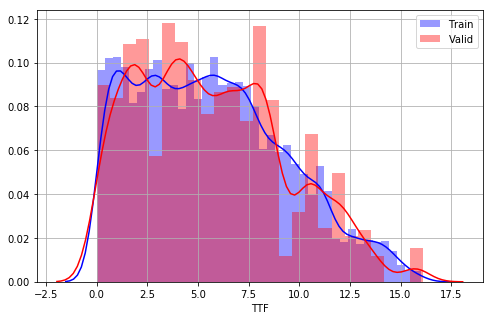

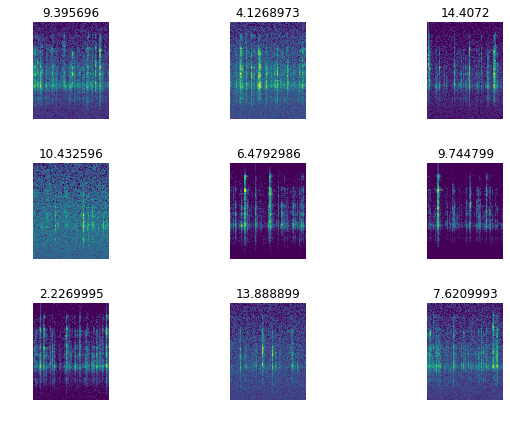

In [20]:
if RUN_REGRESSION:

    LOAD_ONLY = 'freezed' if RUN_REGRESSION==1 else False

    K = len(np.unique(meta.fold))
    print(f'Number of folders:\t{K:d}')

    YV0 = meta.time
    YV = np.zeros(len(meta))
    for k in range(0,K):
        print('Iteration: ',k)
        data = regression_data(meta, k, verbose = (2 if k==0 else 0))
        learn, yt0, yt, yv0, yv = regression_learn(data, cycles=(4,2), mixup=MIXUP, save_label=f'{k:d}', load=LOAD_ONLY)
        YV[meta.fold==k] = yv
    
    YV_crop = np.maximum(np.minimum(YV, 16.5), 0)

    with open(TRAIN/f'regression_results_mixup{MIXUP:d}_freezed.pkl','wb') as fd:
        pkl.dump((YV0, YV, YV_crop), fd)
    
    
else:
    
    with open(TRAIN/f'regression_results_mixup{MIXUP:d}_freezed.pkl','rb') as fd:
        YV0, YV, YV_crop = pkl.load(fd)

Sizes:	 (25165,) (25165,)
MAE:	 2.2187360684389414
MAE per fold:	 [2.12, 2.46, 2.29, 2.17, 2.05]


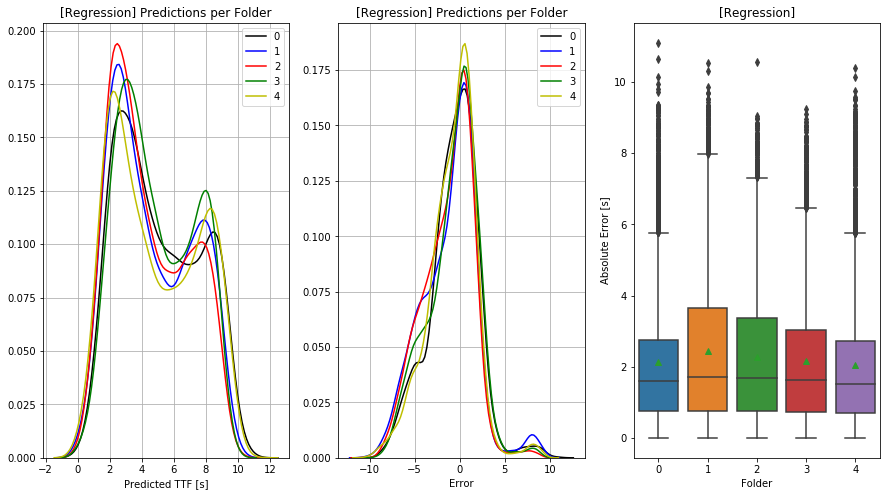

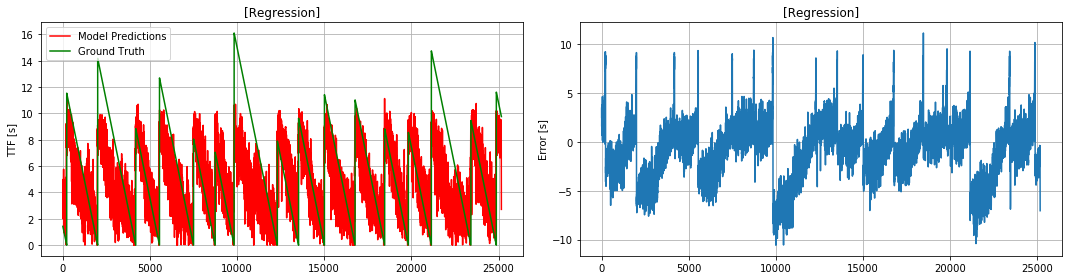

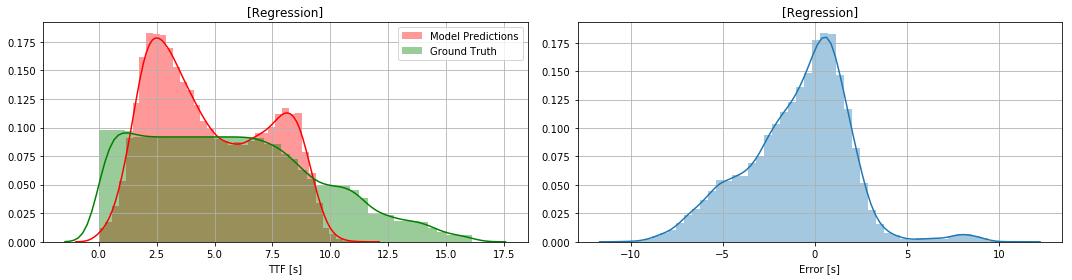

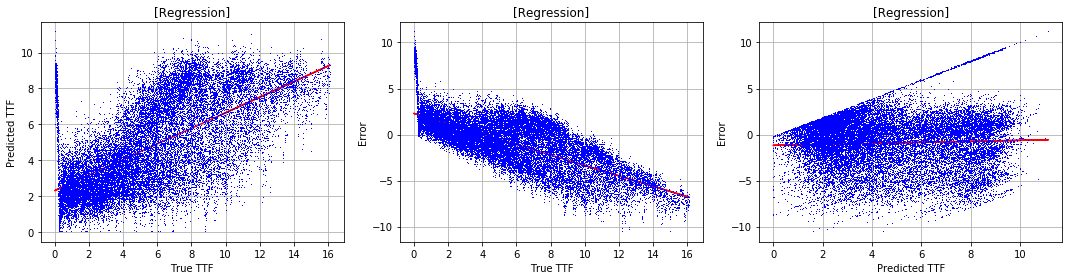

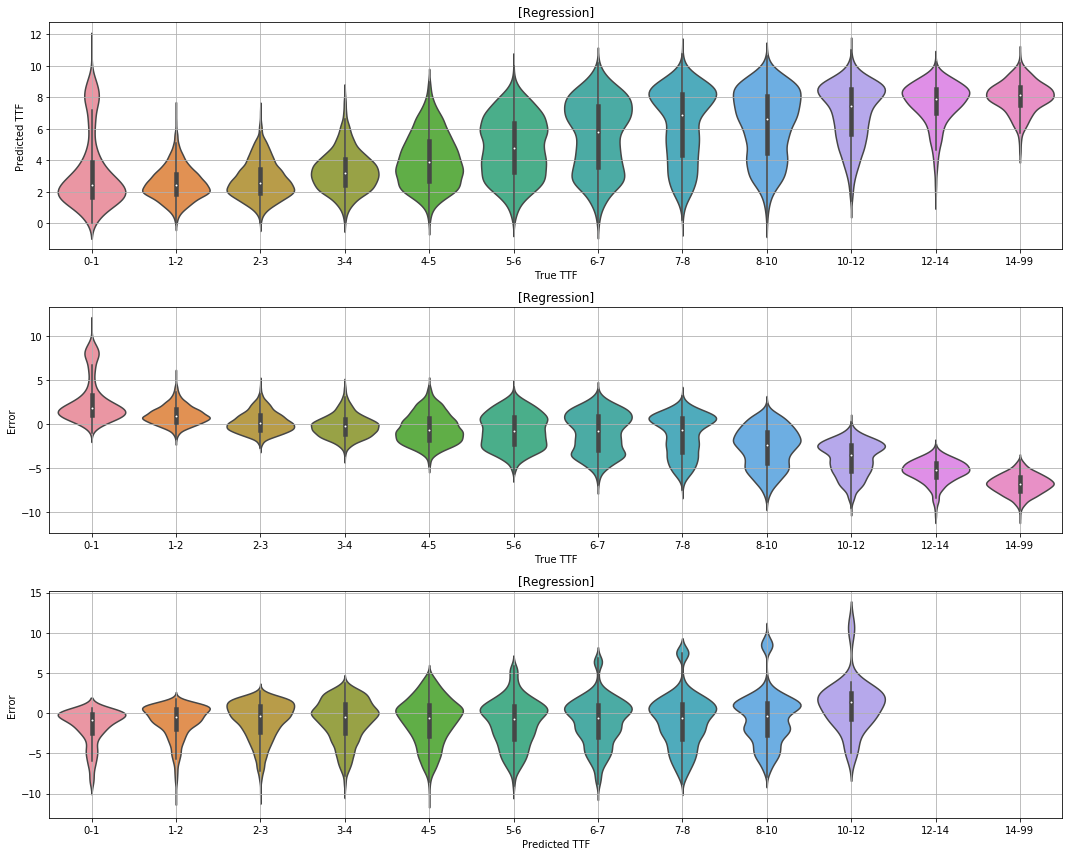

In [21]:
analyze_errors(YV0, YV_crop, 'Regression', meta.fold.values)

Samples:	 (25165,)
MAE - Classification:	 2.208656225178909
MAE - Regression:	 2.2187360684389414


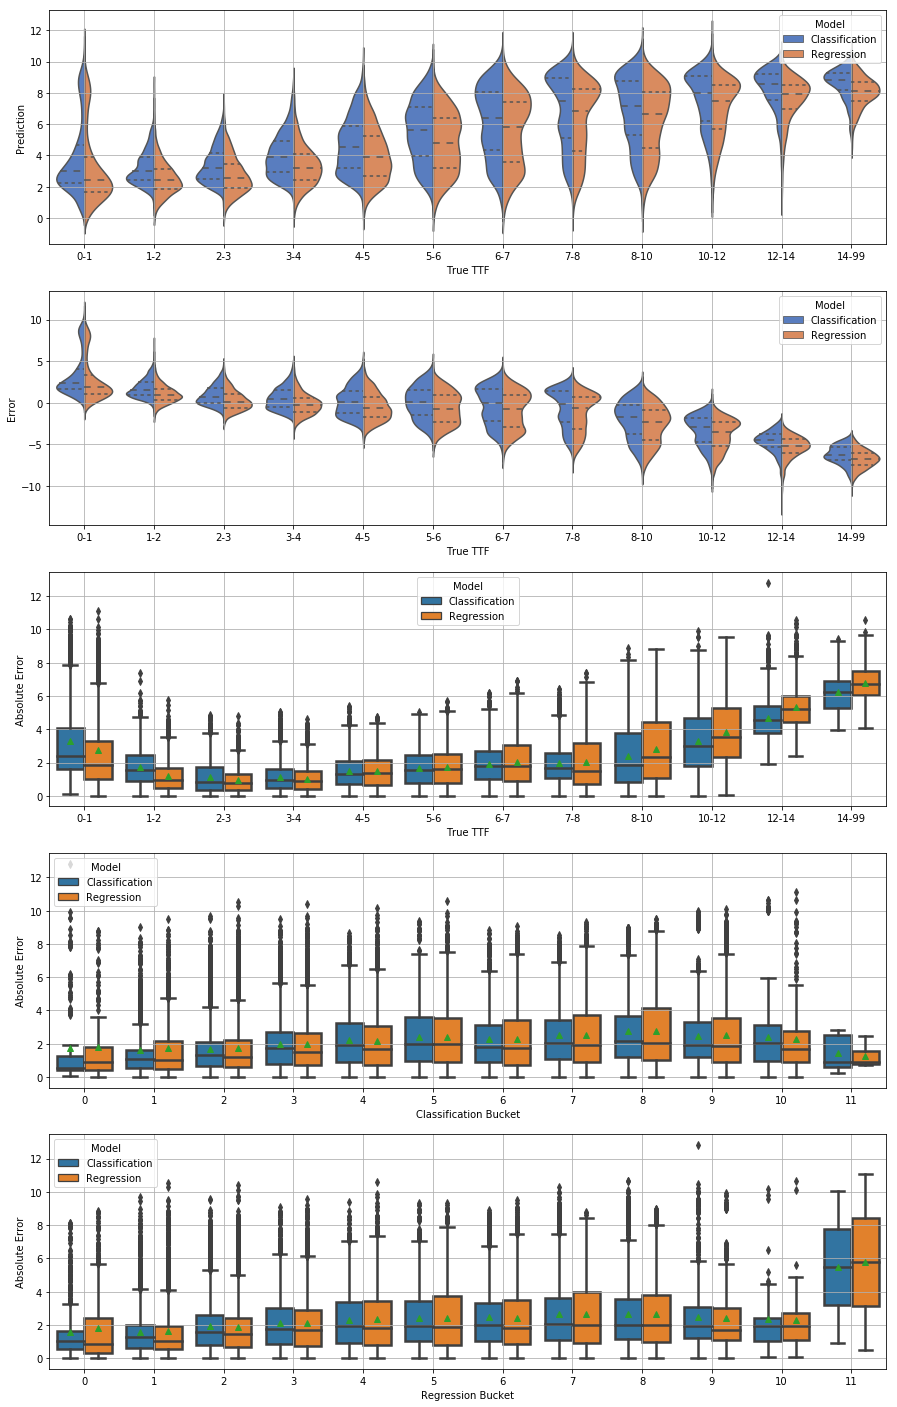

In [22]:
class_vs_reg(YV0, YV_crop, YV_MED)

In [23]:
torch.cuda.empty_cache()